In [1]:
import os
import subprocess
import time
import glob
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

# Import the Deeplsd model

In [2]:
# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  
    'line_detection_params': {
        'merge': False,  
        'filtering': True,  
        'grad_thresh': 3,
        'grad_nfa': True, 
    }
}

# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu')
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

# Import the desired data (Hypersim images)

In [ ]:
#Parameters

frame_str = "0001"

# images
desired_images = [
    "ai_001_001",
    "ai_001_002",
]


files_to_download = [
    f"frame.{frame_str}.color.jpg",
    f"frame.{frame_str}.depth_meters.hdf5",
    f"frame.{frame_str}.normal_world.hdf5",
    f"frame.{frame_str}.normal_bump_world.hdf5",
    f"frame.{frame_str}.position.hdf5"
]

In [ ]:

base_data_dir = "data"
if not os.path.exists(base_data_dir):
    os.makedirs(base_data_dir)
    print(f"Created base data folder: {base_data_dir}")
else:
    print(f"Base data folder {base_data_dir} already exists.")
    

In [3]:

# Download Loop
for image_id in desired_images:
    # Create a folder for the image
    image_dir = os.path.join(base_data_dir, image_id)
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
        print(f"Created folder: {image_dir}")
    else:
        print(f"Folder {image_dir} already exists.")

    # try to download all the required files
    for file_name in files_to_download:
        # Check if the file already exists=
        matching_files = glob.glob(os.path.join(image_dir, "**", file_name), recursive=True)
        if matching_files:
            print(f"File {file_name} already exists in {image_dir} (found: {matching_files[0]}). Skipping download.")
            continue

        # Build the command for download.py.
        cmd = [
            "python", "download.py",
            "--contains", image_id,
            "--contains", file_name,
            "--directory", image_dir,
            "--silent"
        ]
        print(f"Downloading {file_name} for {image_id} ...")
        proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE,
                                text=True, stdin=subprocess.DEVNULL)

        # Poll for file existence, once found, terminate the process.
        timeout = 60
        start_time = time.time()
        while True:
            matching_files = glob.glob(os.path.join(image_dir, "**", file_name), recursive=True)
            if matching_files:
                print(f"File {file_name} downloaded (found: {matching_files[0]}). Terminating process.")
                proc.terminate()  # terminate the download process if found
                break
            if time.time() - start_time > timeout:
                print(f"Timeout reached while waiting for {file_name} in {image_dir}. Killing process.")
                proc.kill()
                break
            time.sleep(10)

        # capture any remaining output.
        try:
            stdout, stderr = proc.communicate(timeout=5)
        except subprocess.TimeoutExpired:
            proc.kill()
            stdout, stderr = proc.communicate()

        if proc.returncode not in [0, None]:
            print(f"Process for {file_name} in {image_id} exited with return code {proc.returncode}.")


Created base data folder: data
Created folder: data/ai_001_001
File frame.0001.color.jpg downloaded (found: data/ai_001_001/ai_001_001/images/scene_cam_00_final_preview/frame.0001.color.jpg). Terminating process.
Process for frame.0001.color.jpg in ai_001_001 exited with return code -15.
File frame.0001.depth_meters.hdf5 downloaded (found: data/ai_001_001/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5). Terminating process.
Process for frame.0001.depth_meters.hdf5 in ai_001_001 exited with return code -15.
File frame.0001.normal_world.hdf5 downloaded (found: data/ai_001_001/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5). Terminating process.
Process for frame.0001.normal_world.hdf5 in ai_001_001 exited with return code -15.
File frame.0001.normal_bump_world.hdf5 downloaded (found: data/ai_001_001/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_bump_world.hdf5). Terminating process.
Process for frame.0001.normal_bump_

# Define Helper Functions

In [13]:
def find_file(image_dir, pattern):
    """"""
    files = glob.glob(os.path.join(image_dir, "**", pattern), recursive=True)
    return files[0] if files else None

def load_color_image(image_dir, frame_str):
    color_file = find_file(image_dir, f"frame.{frame_str}.color.jpg")
    if color_file is None:
        print("Color image not found in", image_dir)
        return None
    img = cv2.imread(color_file)
    if img is None:
        print("Failed to load", color_file)
        return None
    # Convert from BGR to RGB
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def load_depth_map(image_dir, frame_str):
    depth_file = find_file(image_dir, f"frame.{frame_str}.depth_meters.hdf5")
    if depth_file is None:
        print("Depth file not found in", image_dir)
        return None
    with h5py.File(depth_file, 'r') as f:
        depth = np.array(f['dataset'])
    return depth.astype(np.float32)

def load_normal_map(image_dir, frame_str):
    normal_file = find_file(image_dir, f"frame.{frame_str}.normal_world.hdf5")
    if normal_file is None:
        print("Normal file not found in", image_dir)
        return None
    with h5py.File(normal_file, 'r') as f:
        normal = np.array(f['dataset'])
    return normal.astype(np.float32)

def compute_variation(mapping, k):
    """
    Computes the Sobel variation of a mapping (depth or normal) using a kernel size k.
    Normalizes the result by subtracting the mean and dividing by the standard deviation.
    """
    grad_x = cv2.Sobel(mapping, cv2.CV_64F, 1, 0, ksize=k)
    grad_y = cv2.Sobel(mapping, cv2.CV_64F, 0, 1, ksize=k)
    variation = np.sqrt(grad_x**2 + grad_y**2)
    mean = np.mean(variation)
    std_dev = np.std(variation)
    normalized = (variation - mean) / std_dev
    return normalized

def sobel_line(sobel_depth, sobel_normal, line):
    """
    Returns the sobel values along that line for both depth and normal.
    """
    x1, y1 = int(round(line[0, 0])), int(round(line[0, 1]))
    x2, y2 = int(round(line[1, 0])), int(round(line[1, 1]))
    mask_depth = cv2.line(np.zeros_like(sobel_depth), (x1, y1), (x2, y2), 1, 1)
    mask_normal = cv2.line(np.zeros_like(sobel_normal), (x1, y1), (x2, y2), 1, 1)
    return mask_depth * sobel_depth, mask_normal * sobel_normal

def overlay_lines_on_image(image, lines, is_struct):
    """
    Overlays predicted lines on the image.
    """
    overlay = image.copy()
    for i, line in enumerate(lines):
        x1, y1 = int(round(line[0, 0])), int(round(line[0, 1]))
        x2, y2 = int(round(line[1, 0])), int(round(line[1, 1]))
        # In RGB: blue for structural, red for textural.
        color = (0, 0, 255) if is_struct[i] else (255, 0, 0)
        cv2.line(overlay, (x1, y1), (x2, y2), color, thickness=2)
    return overlay



# ===== Extension: Structural Line Classification Using Neighborhood Variation =====

def sobel_line_neighborhood(sobel_depth, sobel_normal, line, thickness=5):
    """
    """
    x1, y1 = int(round(line[0, 0])), int(round(line[0, 1]))
    x2, y2 = int(round(line[1, 0])), int(round(line[1, 1]))
    # Draw a thicker line mask to capture the neighborhood.
    mask_depth = cv2.line(np.zeros_like(sobel_depth), (x1, y1), (x2, y2), 1, thickness=thickness)
    mask_normal = cv2.line(np.zeros_like(sobel_normal), (x1, y1), (x2, y2), 1, thickness=thickness)
    return mask_depth * sobel_depth, mask_normal * sobel_normal

def overlay_lines_on_image_custom(image, lines, is_struct, line_color_struct, line_color_text):
    """
    Overlays predicted lines on the image using custom colors.
    """
    overlay = image.copy()
    for i, line in enumerate(lines):
        x1, y1 = int(round(line[0, 0])), int(round(line[0, 1]))
        x2, y2 = int(round(line[1, 0])), int(round(line[1, 1]))
        color = line_color_struct if is_struct[i] else line_color_text
        cv2.line(overlay, (x1, y1), (x2, y2), color, thickness=2)
    return overlay



# Process all images

# First method


Processing image: ai_001_001 for frame 0001
Detected 414 lines; 137 classified as structural.
Saved composite image with structural/textural lines to data/ai_001_001/composite_lines_0001.png


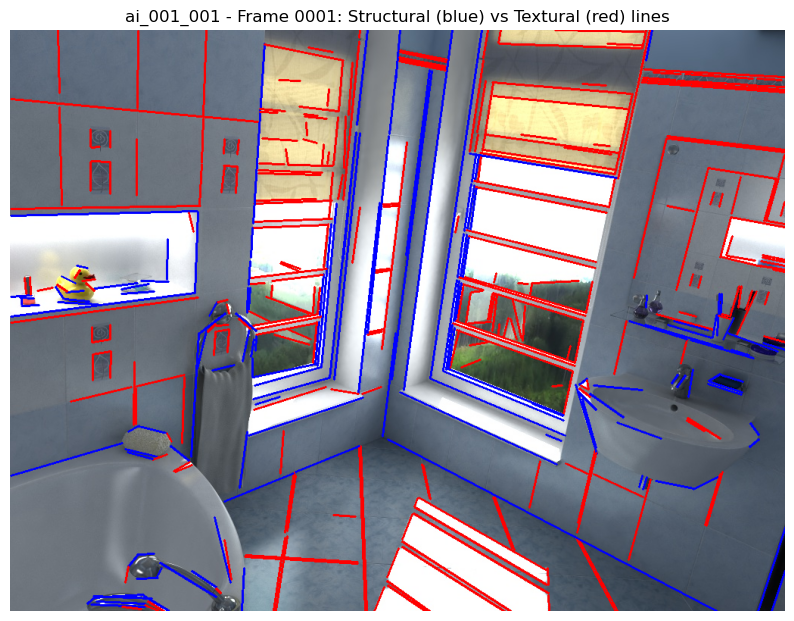


Processing image: ai_001_002 for frame 0001
Detected 153 lines; 71 classified as structural.
Saved composite image with structural/textural lines to data/ai_001_002/composite_lines_0001.png


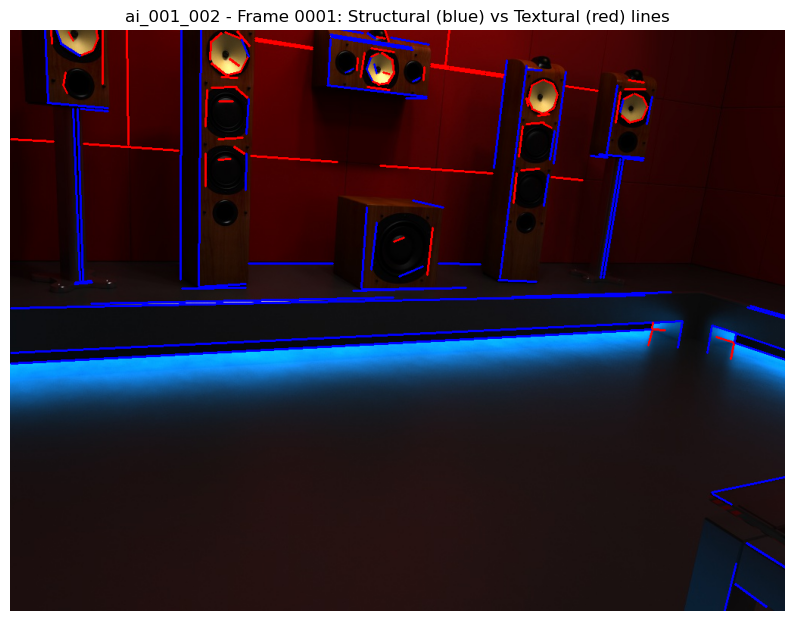

In [9]:
# FIRST method

# Base folder where all downloaded image folders reside
base_data_dir = "data"
# List of downloaded image IDs (folder names)
image_ids = [
    "ai_001_001",
    "ai_001_002",
    # add more image IDs as needed
]

for image_id in image_ids:
    image_dir = os.path.join(base_data_dir, image_id)
    print(f"\nProcessing image: {image_id} for frame {frame_str}")
    
    # Load data
    color_img = load_color_image(image_dir, frame_str)
    depth_map = load_depth_map(image_dir, frame_str)
    normal_map = load_normal_map(image_dir, frame_str)
    
    if color_img is None or depth_map is None or normal_map is None:
        print("Missing data for", image_id, "; skipping.")
        continue
    
    gray_img = cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
    
    
    
    # Detect lines with DeepLSD
    input_tensor = torch.tensor(gray_img, dtype=torch.float32, device=device)[None, None] / 255.
    with torch.no_grad():
        out = net({'image': input_tensor})
        # Get predicted lines from the output. If they are torch.Tensor, convert to numpy.
        pred_lines = out['lines'][0]
        if isinstance(pred_lines, torch.Tensor):
            pred_lines = pred_lines.cpu().numpy()
    
    
    
    # Compute Sobel variation maps for depth and normal.
    sobel_depth_map = compute_variation(depth_map, 11)
    sobel_normal_map = compute_variation(normal_map, 27)
    
    if len(sobel_normal_map.shape) == 3 and sobel_normal_map.shape[2] > 1:
        sobel_normal_map = np.sum(sobel_normal_map, axis=2)
    
    
    
    # For each predicted line, compute variation along the line
    isdepth = []
    isnormal = []
    isstruct = []
    for l in pred_lines:
        ld, ln = sobel_line(sobel_depth_map, sobel_normal_map, l)
        depthbool = np.mean(ld) > 0.0001
        normalbool = np.mean(ln) > 0.0001
        isdepth.append(depthbool)
        isnormal.append(normalbool)
        isstruct.append(depthbool or normalbool)
    
    print(f"Detected {len(pred_lines)} lines; {sum(isstruct)} classified as structural.")
    
    
    
    
    # Overlay the lines on the original image.
    composite = overlay_lines_on_image(color_img, pred_lines, isstruct)
    
    # Save the composite image.
    out_path = os.path.join(image_dir, f"composite_lines_{frame_str}.png")
    composite_bgr = cv2.cvtColor(composite, cv2.COLOR_RGB2BGR)
    cv2.imwrite(out_path, composite_bgr)
    print(f"Saved composite image with structural/textural lines to {out_path}")
    
    # Display the composite image.
    plt.figure(figsize=(10, 10))
    plt.imshow(composite)
    plt.title(f"{image_id} - Frame {frame_str}: Structural (blue) vs Textural (red) lines")
    plt.axis('off')
    plt.show()

# Second method


[Neighborhood Method] Processing image: ai_001_001 for frame 0001
[Neighborhood Method] Detected 414 lines; 193 classified as structural.
Saved composite neighborhood-based image to data/ai_001_001/composite_lines_neighborhood_0001.png


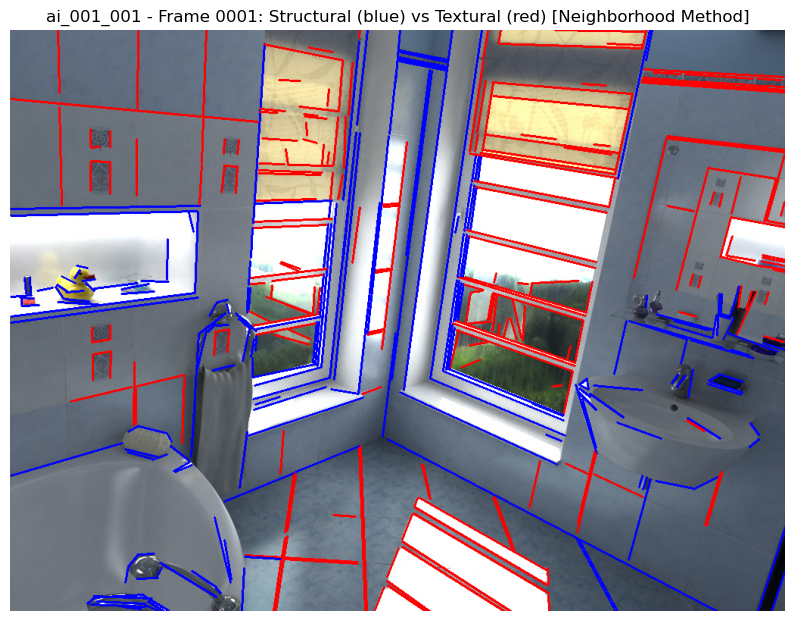


[Neighborhood Method] Processing image: ai_001_002 for frame 0001
[Neighborhood Method] Detected 153 lines; 135 classified as structural.
Saved composite neighborhood-based image to data/ai_001_002/composite_lines_neighborhood_0001.png


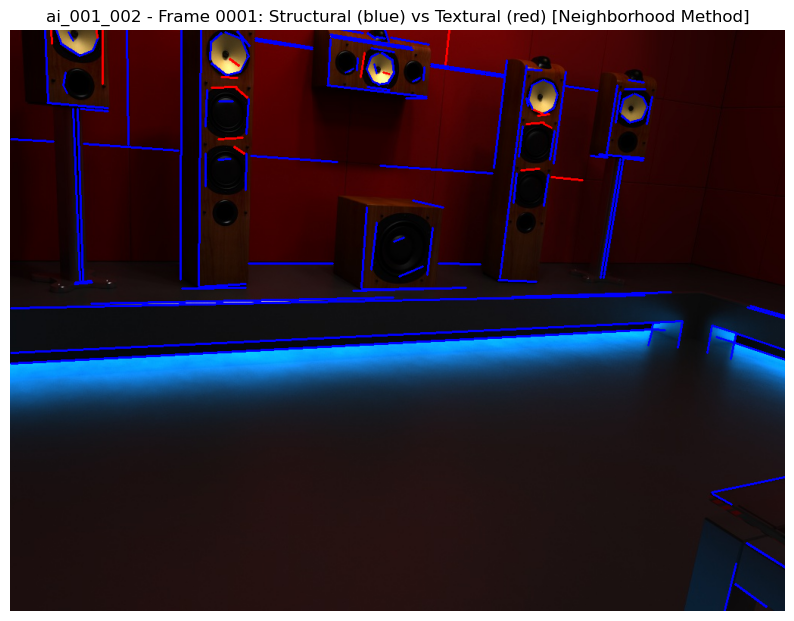

In [36]:
#Method 2

# PARAMETERS
NEIGHBORHOOD_DEPTH_THRESHOLD = 0.0005
NEIGHBORHOOD_NORMAL_THRESHOLD = 0.0005
thickness = 10



for image_id in image_ids:
    image_dir = os.path.join(base_data_dir, image_id)
    print(f"\n[Neighborhood Method] Processing image: {image_id} for frame {frame_str}")
    
    # Load the data
    color_img = load_color_image(image_dir, frame_str)
    depth_map = load_depth_map(image_dir, frame_str)
    normal_map = load_normal_map(image_dir, frame_str)
    
    if color_img is None or depth_map is None or normal_map is None:
        print("Missing data for", image_id, "; skipping.")
        continue
    
    gray_img = cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)

    
    
    # Detect lines with DeepLSD
    input_tensor = torch.tensor(gray_img, dtype=torch.float32, device=device)[None, None] / 255.
    with torch.no_grad():
        out = net({'image': input_tensor})
        pred_lines = out['lines'][0]
        if isinstance(pred_lines, torch.Tensor):
            pred_lines = pred_lines.cpu().numpy()
    
    
    
    # Compute Sobel variation maps for depth and normal.
    sobel_depth_map = compute_variation(depth_map, 11)
    sobel_normal_map = compute_variation(normal_map, 27)
    if len(sobel_normal_map.shape) == 3 and sobel_normal_map.shape[2] > 1:
        sobel_normal_map = np.sum(sobel_normal_map, axis=2)
    
    
    
    # Classify each predicted line
    isstruct_neighborhood = []
    for l in pred_lines:
        ld_neigh, ln_neigh = sobel_line_neighborhood(sobel_depth_map, sobel_normal_map, l, thickness=thickness)
        depth_bool_neigh = np.mean(ld_neigh) > NEIGHBORHOOD_DEPTH_THRESHOLD
        normal_bool_neigh = np.mean(ln_neigh) > NEIGHBORHOOD_NORMAL_THRESHOLD
        isstruct_neighborhood.append(depth_bool_neigh or normal_bool_neigh)
    
    print(f"[Neighborhood Method] Detected {len(pred_lines)} lines; {sum(isstruct_neighborhood)} classified as structural.")
    
    
    
    # Output image
    composite_neighborhood = overlay_lines_on_image_custom(
        color_img, pred_lines, isstruct_neighborhood,
        line_color_struct=(0, 0, 255),  # blue for structural
        line_color_text=(255, 0, 0)     # red for textural
    )
    
    # Save the composite image.
    out_path_neighborhood = os.path.join(image_dir, f"composite_lines_neighborhood_{frame_str}.png")
    cv2.imwrite(out_path_neighborhood, cv2.cvtColor(composite_neighborhood, cv2.COLOR_RGB2BGR))
    print(f"Saved composite neighborhood-based image to {out_path_neighborhood}")
    
    # Display the composite image.
    plt.figure(figsize=(10, 10))
    plt.imshow(composite_neighborhood)
    plt.title(f"{image_id} - Frame {frame_str}: Structural (blue) vs Textural (red) [Neighborhood Method]")
    plt.axis('off')
    plt.show()
